In [19]:
from huggingface_hub import hf_hub_download
import pandas as pd

# Download the Diamond dataset
file_path = hf_hub_download(
    repo_id="idavidrein/gpqa", filename="gpqa_diamond.csv", repo_type="dataset")

# Load into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

                               Pre-Revision Question  \
0  Two quantum states with energies E1 and E2 hav...   
1  trans-cinnamaldehyde was treated with methylma...   
2  A spin-half particle is in a linear superposit...   
3  In a parallel universe where a magnet can have...   
4  Calculate the eigenvector of a quantum mechani...   

                         Pre-Revision Correct Answer  \
0                                           10^-4 ev   
1                                                 11   
2                                                7.6   
3  The ones related to the circulation of the ele...   
4                (\cos(\theta/2), \sin (\theta/2))\n   

                     Pre-Revision Incorrect Answer 1  \
0                                           10^-8 ev   
1                                                 10   
2                                                7.2   
3  The ones related to the divergence and the cur...   
4               (\sqrt{2/3}\hbar, \sqrt{1/3}\h

In [20]:
import pandas as pd

# Load the Diamond dataset
dataset_path = "gpqa_diamond.csv"
df = pd.read_csv(dataset_path)

# Display the first few rows
print(df.head())

                               Pre-Revision Question  \
0  Two quantum states with energies E1 and E2 hav...   
1  trans-cinnamaldehyde was treated with methylma...   
2  A spin-half particle is in a linear superposit...   
3  In a parallel universe where a magnet can have...   
4  Calculate the eigenvector of a quantum mechani...   

                         Pre-Revision Correct Answer  \
0                                           10^-4 ev   
1                                                 11   
2                                                7.6   
3  The ones related to the circulation of the ele...   
4                (\cos(\theta/2), \sin (\theta/2))\n   

                     Pre-Revision Incorrect Answer 1  \
0                                           10^-8 ev   
1                                                 10   
2                                                7.2   
3  The ones related to the divergence and the cur...   
4               (\sqrt{2/3}\hbar, \sqrt{1/3}\h

In [21]:
print(df["High-level domain"].value_counts())

High-level domain
Chemistry    93
Physics      86
Biology      19
Name: count, dtype: int64


<Axes: xlabel='High-level domain'>

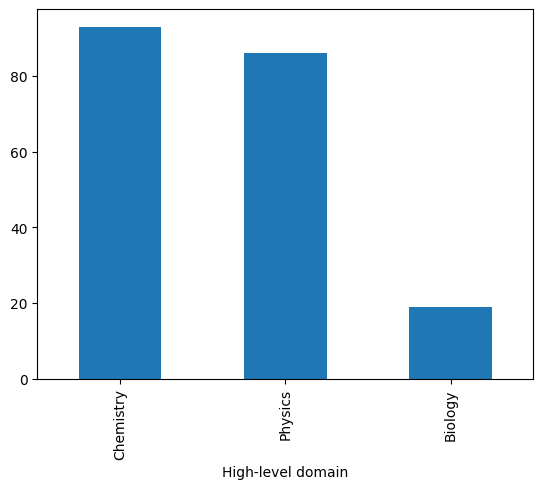

In [22]:
df["High-level domain"].value_counts().plot(kind="bar")

In [23]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [34]:
import pandas as pd
from datasets import Dataset

# Load the CSV
df = pd.read_csv("gpqa_diamond.csv")

# Assuming columns: "Question", "Correct", "Incorrect_1", "Incorrect_2", "Incorrect_3"
# Combine question and options into a single input


def format_input(row):
    options = [row['Pre-Revision Correct Answer'], row['Pre-Revision Incorrect Answer 1'],
               row['Pre-Revision Incorrect Answer 2'], row['Pre-Revision Incorrect Answer 3']]
    labels = ["A", "B", "C", "D"]
    formatted_options = "\n".join(
        [f"{label}: {opt}" for label, opt in zip(labels, options)])
    return f"{row['Question']}\n{formatted_options}"


df["input_text"] = df.apply(format_input, axis=1)
df["label"] = 0  # Label 0 for "Correct" (A), adjust if needed

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df[["input_text", "label"]])
dataset = dataset.train_test_split(test_size=0.1)  # 90% train, 10% eval
dataset["train"][0]

{'input_text': 'Astronomers are studying a system of three exoplanets (Planet1, Planet2, and Planet3) with circular orbits discovered through the TTV method. They have found that the ratio of the equilibrium temperatures between Planet1 and Planet2 is approximately 1.4, and between Planet2 and Planet3, it is about 2.3. They have also found that the ratio of the masses between Planet1 and Planet2 is approximately 1.15, and between Planet2 and Planet3, it is about 1.35. By what factor is the orbital period of Planet3 larger than that of Planet1, if the albedo for all three planets is equal to 0.3 (similar to that of Earth)?\nA: ~ 33.4\nB: ~ 3.2\nC: ~ 10.4\nD: ~ 4.4',
 'label': 0}

In [25]:
import pandas as pd

# Load the CSV
df = pd.read_csv("gpqa_diamond.csv")

# Print column names
print("Column names in the dataset:")
print(df.columns.tolist())

# Print the first few rows to see the data
print("\nFirst few rows of the dataset:")
print(df.head())

Column names in the dataset:
['Pre-Revision Question', 'Pre-Revision Correct Answer', 'Pre-Revision Incorrect Answer 1', 'Pre-Revision Incorrect Answer 2', 'Pre-Revision Incorrect Answer 3', 'Pre-Revision Explanation', 'Self-reported question-writing time (minutes)', 'Question', 'Correct Answer', 'Incorrect Answer 1', 'Incorrect Answer 2', 'Incorrect Answer 3', 'Explanation', 'Revision Comments (from Question Writer)', 'Subdomain', "Writer's Difficulty Estimate", 'Extra Revised Question', 'Extra Revised Explanation', 'Extra Revised Correct Answer', 'Extra Revised Incorrect Answer 1', 'Extra Revised Incorrect Answer 2', 'Extra Revised Incorrect Answer 3', 'Non-Expert Validator Accuracy', 'Majority Non-Expert Vals Incorrect', 'Expert Validator Accuracy', 'Record ID', 'High-level domain', 'Question Writer', 'Feedback_EV_1', 'Validator Revision Suggestion_EV_1', 'Is First Validation_EV_1', 'Post hoc agreement_EV_1', 'Sufficient Expertise?_EV_1', 'Understand the question?_EV_1', 'Question D

In [26]:
import torch

In [27]:
from transformers import (
    DistilBertTokenizer,
    DistilBertForMultipleChoice,
    Trainer,
    TrainingArguments,
)

In [28]:
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig

In [29]:
# Load tokenizer and model with 4-bit quantization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
quantization_config = BitsAndBytesConfig(load_in_4bit=True)
model = DistilBertForMultipleChoice.from_pretrained(
    "distilbert-base-uncased",
    num_labels=4,  # A, B, C, D
    quantization_config=quantization_config,
    # device_map="auto"  # Automatically uses GPU
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Apply LoRA
lora_config = LoraConfig(
    r=8,  # Rank of LoRA
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "k_lin", "v_lin"]  # DistilBERT attention layers
)
model = get_peft_model(model, lora_config)

In [ ]:
# dataset = load_dataset("csv", data_files="gpqa_diamond.csv", split="train")
# dataset = dataset.train_test_split(test_size=0.1)

In [35]:
df["input_text"]

0      Two quantum states with energies E1 and E2 hav...
1      trans-cinnamaldehyde was treated with methylma...
2      A spin-half particle is in a linear superposit...
3      In a parallel universe where a magnet can have...
4      Calculate the eigenvector of a quantum mechani...
                             ...                        
193    Consider a system of three spins S1, S2 and S3...
194    Astronomers are observing a planet with a radi...
195     Consider a 1-dimensional relativistic harmoni...
196    Compound X, which has the following IR and NMR...
197    We have a solution containing Co(II) ions and ...
Name: input_text, Length: 198, dtype: object

In [41]:
def preprocess_function(examples):
    inputs = [ex.split("\n")[0] for ex in examples["input_text"]]  # Question
    options = [ex.split("\n")[1:] for ex in examples["input_text"]]  # Options
    tokenized = tokenizer(
        inputs,
        # Only first option for simplicity; adjust if needed
        [opt[0] for opt in options],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    tokenized["labels"] = examples["label"]
    return tokenized


tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [39]:
def preprocess_function(examples):
    # Split input_text into question and options
    questions = [ex.split("\n")[0] for ex in examples["input_text"]]
    # Take 4 options (A, B, C, D)
    options = [ex.split("\n")[1:5] for ex in examples["input_text"]]

    # Flatten inputs: [batch_size * num_choices] question-option pairs
    num_choices = 4
    flat_questions = [q for q in questions for _ in range(num_choices)]
    flat_options = [opt[i].split(": ")[1]
                    for opt in options for i in range(num_choices)]

    # Tokenize all question-option pairs
    tokenized = tokenizer(
        flat_questions,
        flat_options,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )

    # Reshape to [batch_size, num_choices, sequence_length]
    for key in ["input_ids", "attention_mask"]:
        tokenized[key] = tokenized[key].view(-1, num_choices, 512)

    # Add labels
    tokenized["labels"] = torch.tensor(examples["label"], dtype=torch.long)

    return tokenized

In [42]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
print("Tokenized training dataset sample:")
print(tokenized_dataset["train"][0])  # Print first example
print("Keys in tokenized dataset:", tokenized_dataset["train"].features)

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenized training dataset sample:
{'input_text': 'Astronomers are studying a system of three exoplanets (Planet1, Planet2, and Planet3) with circular orbits discovered through the TTV method. They have found that the ratio of the equilibrium temperatures between Planet1 and Planet2 is approximately 1.4, and between Planet2 and Planet3, it is about 2.3. They have also found that the ratio of the masses between Planet1 and Planet2 is approximately 1.15, and between Planet2 and Planet3, it is about 1.35. By what factor is the orbital period of Planet3 larger than that of Planet1, if the albedo for all three planets is equal to 0.3 (similar to that of Earth)?\nA: ~ 33.4\nB: ~ 3.2\nC: ~ 10.4\nD: ~ 4.4', 'label': 0, 'input_ids': [101, 26357, 2024, 5702, 1037, 2291, 1997, 2093, 4654, 7361, 20644, 3215, 1006, 4774, 2487, 1010, 4774, 2475, 1010, 1998, 4774, 2509, 1007, 2007, 8206, 20347, 3603, 2083, 1996, 23746, 2615, 4118, 1012, 2027, 2031, 2179, 2008, 1996, 6463, 1997, 1996, 14442, 7715, 209

In [46]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./gpqa_finetuned",
    per_device_train_batch_size=1,  # Small batch size for 4GB VRAM
    per_device_eval_batch_size=1,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    fp16=True,  # Mixed precision for efficiency
    load_best_model_at_end=True,
)

In [47]:
tokenized_dataset["train"][0]

{'input_text': 'Astronomers are studying a system of three exoplanets (Planet1, Planet2, and Planet3) with circular orbits discovered through the TTV method. They have found that the ratio of the equilibrium temperatures between Planet1 and Planet2 is approximately 1.4, and between Planet2 and Planet3, it is about 2.3. They have also found that the ratio of the masses between Planet1 and Planet2 is approximately 1.15, and between Planet2 and Planet3, it is about 1.35. By what factor is the orbital period of Planet3 larger than that of Planet1, if the albedo for all three planets is equal to 0.3 (similar to that of Earth)?\nA: ~ 33.4\nB: ~ 3.2\nC: ~ 10.4\nD: ~ 4.4',
 'label': 0,
 'input_ids': [101,
  26357,
  2024,
  5702,
  1037,
  2291,
  1997,
  2093,
  4654,
  7361,
  20644,
  3215,
  1006,
  4774,
  2487,
  1010,
  4774,
  2475,
  1010,
  1998,
  4774,
  2509,
  1007,
  2007,
  8206,
  20347,
  3603,
  2083,
  1996,
  23746,
  2615,
  4118,
  1012,
  2027,
  2031,
  2179,
  2008,
 

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

# Fine-tune
trainer.train()

In [ ]:
# Save the model
model.save_pretrained("./gpqa_finetuned/final_model")
tokenizer.save_pretrained("./gpqa_finetuned/final_model")